In [1]:
import sys 
sys.path.append("../")
from wave_circuit import * 
from mps_utils import * 
from density import * 

from qiskit.quantum_info import Statevector
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset
from matplotlib.patches import Rectangle
from matplotlib.patches import ConnectionPatch
from matplotlib.lines import Line2D

results = np.load("results.npy", allow_pickle=True)
n = 10
i = 4 
opt_layers = [results[i].point[j*(n-1):(j+1)*(n-1)] for j in range(i+1)]

# Physics-themed pastel colors
colors = {
    'kinetic': '#FF9999',      # Soft red for kinetic energy
    'potential': '#99CCFF',    # Soft blue for potential energy  
    'total': '#CC99FF',        # Soft purple for total energy
    'kinetic_data': '#FFB366', # Soft orange for kinetic data
    'potential_data': '#66B3FF', # Soft cyan for potential data
    'total_data': '#B366FF'    # Soft magenta for total data
}

In [2]:
### Test Depolarizing Noise Channel ###

rho = random_density(2)
lam = 0.05 

depolar_rho = (1 - 3/4 * lam) * rho + \
              lam/4 * np.kron(X, np.eye(2)) @ rho @ np.kron(X, np.eye(2)) + \
              lam/4 * np.kron(Y, np.eye(2)) @ rho @ np.kron(Y, np.eye(2)) + \
              lam/4 * np.kron(Z, np.eye(2)) @ rho @ np.kron(Z, np.eye(2))  
              
apply_single_qubit_depolarizing_inplace(rho, lam, 0, 2)  ### In-place update
print("Single Qubit Error: ", np.linalg.norm(rho - depolar_rho))


rho = random_density(2)
lam = 0.05 

depolar_rho = (1 - 15/16 * lam) * rho 
for op1 in [np.eye(2),X,Y,Z]:
    for op2 in [np.eye(2),X,Y,Z]:
        if(not np.all(np.isclose(op1, np.eye(2))) or not np.all(np.isclose(op2, np.eye(2)))):
            depolar_rho += lam/16 * np.kron(op1, op2) @ rho @ np.kron(op1, op2)
              
apply_two_qubit_depolarizing_inplace(rho, lam, 0, 1, 2)  ### In-place update
print("Two Qubit Error: ",np.linalg.norm(rho - depolar_rho))

Single Qubit Error:  7.238184373059934e-17
Two Qubit Error:  2.453330797663438e-16


In [3]:
sigma = 0.1 
mu = 0.5
n = 10
N = 2**n

f = lambda x: 2/(np.sqrt(3 * sigma) * (np.pi)**(1/4)) * (1 - ((x-mu)/sigma)**2 ) * np.exp(- (x-mu)**2/(2*sigma**2))
df = lambda x: -4/(np.sqrt(3 * sigma) * (np.pi)**(1/4)) * (x-mu)/(sigma**2) * np.exp(- (x-mu)**2/(2*sigma**2)) - (x-mu)/(sigma**2) * f(x)


init_state = f(np.linspace(0,1-1/N,N) + 1/(2*N))
init_state = np.concatenate([init_state, np.zeros(N)])
K = np.linalg.norm(init_state)
init_state = init_state/K

f_extend = lambda x : f(x - np.floor(x))/K
df_extend = lambda x : df(x - np.floor(x))/K


f_evo = lambda x,t :  1/2 * (f_extend(x - t) + f_extend(x + t))
dxf_evo = lambda x,t :1/2 * (df_extend(x - t) + df_extend(x + t))
dtf_evo = lambda x,t : 1/2 * (-df_extend(x - t) + df_extend(x + t))

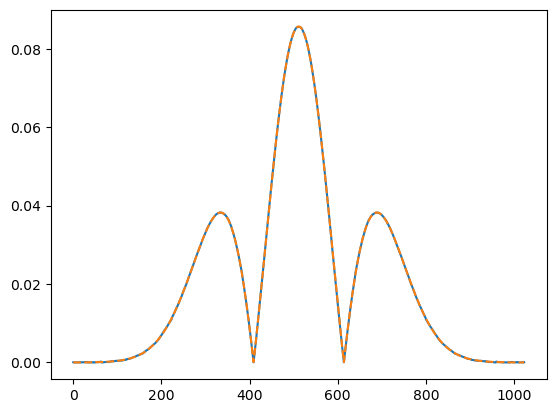

In [4]:
state_prep_circ = QuantumCircuit(n)
state_prep_circ = state_prep_circ.compose(convert_layers_to_circuit(opt_layers), range(1,n))
state_prep_circ.h(0)
for i in range(1,n):
    state_prep_circ.cx(0, i)
plt.plot(abs(Statevector(state_prep_circ.reverse_bits()).data))
plt.plot([abs(f_evo(_,0)) for _ in (np.linspace(0,1-1/N,N) + 1/(2*N))], '--')

In [5]:
exact_state = f(np.linspace(0,1-1/N,N) + 1/(2*N))
exact_state = exact_state/K 
1-abs(np.dot(exact_state, Statevector(state_prep_circ.reverse_bits()).data))**2

np.float64(3.220621400790158e-06)

In [6]:
def n_int(fun):
    return 1/N * np.sum([fun(_) for _ in np.linspace(0,1-1/N,N) + 1/(2*N)])

def T(t):
    return n_int(lambda x : dtf_evo(x,t)**2)

def U(t):
    return n_int(lambda x : dxf_evo(x,t)**2)

In [7]:
U(0.1)

np.float64(0.05319625640899778)

In [8]:
eval_time = 0.1
full_circuit = QuantumCircuit(n+1)
full_circuit = full_circuit.compose(state_prep_circ, range(1,n+1))
full_circuit = full_circuit.compose(energy_circuit(n, swap=False).assign_parameters([eval_time]), range(n+1))
state = Statevector(full_circuit.reverse_bits()).data
energy_expectation(state, swap = True), U(eval_time), T(eval_time)

((np.complex128(0.05404165759306771+3.701242368043109e-19j),
  np.complex128(0.19204047438810148-6.940088751761777e-18j)),
 np.float64(0.05319625640899778),
 np.float64(0.19094436614153792))

In [9]:
rho = get_density_matrix(full_circuit, 0)
spec = np.clip(spectrum_P(N), -4, 0)
swap = np.kron(np.eye(2), swap_matrix(n))

U_op =-N * swap @ np.block([[np.diag(spec), np.zeros((N,N))], [np.zeros((N,N)), np.zeros((N,N))]]) @ swap
T_op =-N * swap @ np.block([[np.zeros((N,N)), np.zeros((N,N))], [np.zeros((N,N)), np.diag(spec)]]) @ swap

U_targ = np.trace(np.dot(U_op, rho)).real
T_targ = np.trace(np.dot(T_op, rho)).real

print(U_targ,T_targ)

0.054041657593695204 0.1920404743887425


In [10]:
U_list  = []
T_list  = []
for fold_prob in np.linspace(0,1,2):
    
    folded_circ = fold_circ(full_circuit, int(fold_prob))
    rho = get_density_matrix(folded_circ, 5e-6)

    U_list.append(np.trace(np.dot(U_op, rho)).real)
    T_list.append(np.trace(np.dot(T_op, rho)).real)

    print(fold_prob)

0.0
1.0


C:\Users\bik19\AppData\Local\Temp\ipykernel_28484\3327468909.py:119: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


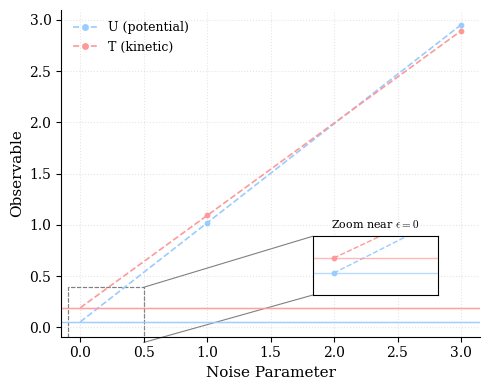

In [11]:
plt.rcParams.update({
    "mathtext.fontset": "cm",    # Computer Modern
    "font.family": "serif",
    "font.size": 10
})
fig, ax = plt.subplots(figsize=(5, 4))

x_vals= 1 + 2 * np.linspace(0,1,2)

# --- U data ---
u_scatter = ax.scatter(x_vals, U_list, 
                       color=colors['potential'],
                       marker='o', 
                       s=10)
U_fit = exponential_fit(x_vals, U_list, N)
x_fit = np.linspace(0, 3, 1000)
u_line, = ax.plot(x_fit, U_fit(x_fit), '--', color=colors['potential'], linewidth=1.2)

# --- T data ---
y_scatter = ax.scatter(x_vals, T_list, 
                       color=colors['kinetic'],
                       marker='o', 
                       s=10)
T_fit = exponential_fit(x_vals, T_list, N)
t_line, = ax.plot(x_fit, T_fit(x_fit), '--', color=colors['kinetic'], linewidth=1.2)

# Target lines (don't include in legend)
ax.axhline(U_targ, color=colors['potential'], linewidth=1, alpha=0.7)
ax.axhline(T_targ, color=colors['kinetic'], linewidth=1, alpha=0.7)

# --- Custom legend handles ---
legend_handles = [
    Line2D([0], [0], color=colors['potential'], linestyle='--', linewidth=1.2,
           marker='o', markerfacecolor=colors['potential'], markeredgecolor='white', markersize=6,
           label="U (potential)"),
    Line2D([0], [0], color=colors['kinetic'], linestyle='--', linewidth=1.2,
           marker='o', markerfacecolor=colors['kinetic'], markeredgecolor='white', markersize=6,
           label="T (kinetic)")
]

ax.legend(handles=legend_handles, frameon=False, fontsize=9, loc="best")

# Labels
ax.set_xlabel("Noise Parameter", fontsize=11)
ax.set_ylabel("Observable", fontsize=11)

# Grid
ax.grid(True, alpha=0.3, linestyle=':', color='#aaa')

# Target lines
ax.axhline(U_targ, color=colors['potential'], linewidth=1, alpha=0.7)
ax.axhline(T_targ, color=colors['kinetic'], linewidth=1, alpha=0.7)

# Legend
ax.legend(handles=legend_handles, frameon=False, fontsize=9, loc="best")

# --- Inset zoom near (0,0) ---
axins = inset_axes(ax, width="30%", height="18%", loc="lower right", borderpad=3)

# Fits
axins.plot(x_fit, U_fit(x_fit), '--', color=colors['potential'], linewidth=1)
axins.plot(x_fit, T_fit(x_fit), '--', color=colors['kinetic'], linewidth=1)

axins.scatter([0], [U_fit(0)],
               color=colors['potential'], 
               marker='o', s=10)
axins.scatter([0], [T_fit(0)], 
               color=colors['kinetic'], 
               marker='o', s=10)

# Target lines
axins.axhline(U_targ, color=colors['potential'], linewidth=1, alpha=0.7)
axins.axhline(T_targ, color=colors['kinetic'], linewidth=1, alpha=0.7)

# Zoom window
axins.set_xlim(-0.1, 0.5)
ymin = min(U_targ, T_targ) - 0.2
ymax = max(U_targ, T_targ) + 0.2
axins.set_ylim(ymin, ymax)

# Clean look: no ticks
axins.set_xticks([])
axins.set_yticks([])

# Inset title
axins.set_title("Zoom near $\\epsilon=0$", fontsize=8)

# Draw rectangle on main plot (zoom region)
rect = Rectangle((-0.1, ymin), 0.6, ymax-ymin,
                 linewidth=0.8, edgecolor="gray",
                 facecolor="none", linestyle="--")
ax.add_patch(rect)

# Custom connector lines (right edge of rectangle → left edge of inset)
xyA_top    = (0.5, ymax)       # top-right corner of rectangle (main axes coords)
xyA_bottom = (0.5, ymin)       # bottom-right corner of rectangle
xyB_top    = (0, 1)            # top-left of inset (axes fraction coords)
xyB_bottom = (0, 0)            # bottom-left of inset

# Top connector
con1 = ConnectionPatch(xyA=xyA_top, coordsA=ax.transData,
                       xyB=xyB_top, coordsB=axins.transAxes,
                       color="0.5", lw=0.8)
# Bottom connector
con2 = ConnectionPatch(xyA=xyA_bottom, coordsA=ax.transData,
                       xyB=xyB_bottom, coordsB=axins.transAxes,
                       color="0.5", lw=0.8)

ax.add_artist(con1)
ax.add_artist(con2)

# Rectangle on main plot
rect = Rectangle((-0.1, ymin), 0.6, ymax-ymin,
                 linewidth=0.8, edgecolor="gray",
                 facecolor="none", linestyle="--")
ax.add_patch(rect)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.tight_layout()
plt.savefig("../Finalized Figures/ZNE_expm.pdf", dpi=300)
plt.show()

In [12]:
U_fit(0),U(eval_time), U_targ

(np.float64(0.054541886194215294),
 np.float64(0.05319625640899778),
 np.float64(0.054041657593695204))

In [13]:
T_fit(0), T(eval_time), T_targ

(np.float64(0.19242045411476738),
 np.float64(0.19094436614153792),
 np.float64(0.1920404743887425))

In [14]:
U_ZNE = []
T_ZNE = []
for eval_time in np.linspace(0, 1, 101):
    full_circuit = QuantumCircuit(n+1)
    full_circuit = full_circuit.compose(state_prep_circ, range(1,n+1))
    full_circuit = full_circuit.compose(energy_circuit(n, swap=False).assign_parameters([eval_time]), range(n+1))

    U_list  = []
    T_list  = []
    for fold_prob in np.linspace(0, 1, 2):
        folded_circ = fold_circ(full_circuit, fold_prob)
        rho = get_density_matrix(folded_circ, 5e-6)
        U_list.append(np.trace(np.dot(U_op, rho)).real)
        T_list.append(np.trace(np.dot(T_op, rho)).real)
    
    U_fit = exponential_fit(x_vals, U_list, N)
    T_fit = exponential_fit(x_vals, T_list, N)
    
    U_ZNE.append(U_fit(0))
    T_ZNE.append(T_fit(0))
    print(eval_time)

0.0
0.01
0.02
0.03
0.04
0.05
0.06
0.07
0.08
0.09
0.1
0.11
0.12
0.13
0.14
0.15
0.16
0.17
0.18
0.19
0.2
0.21
0.22
0.23
0.24
0.25
0.26
0.27
0.28
0.29
0.3
0.31
0.32
0.33
0.34
0.35000000000000003
0.36
0.37
0.38
0.39
0.4
0.41000000000000003
0.42
0.43
0.44
0.45
0.46
0.47000000000000003
0.48
0.49
0.5
0.51
0.52
0.53
0.54
0.55
0.56
0.5700000000000001
0.58
0.59
0.6
0.61
0.62
0.63
0.64
0.65
0.66
0.67
0.68
0.6900000000000001
0.7000000000000001
0.71
0.72
0.73
0.74
0.75
0.76
0.77
0.78
0.79
0.8
0.81
0.8200000000000001
0.8300000000000001
0.84
0.85
0.86
0.87
0.88
0.89
0.9
0.91
0.92
0.93
0.9400000000000001
0.9500000000000001
0.96
0.97
0.98
0.99
1.0


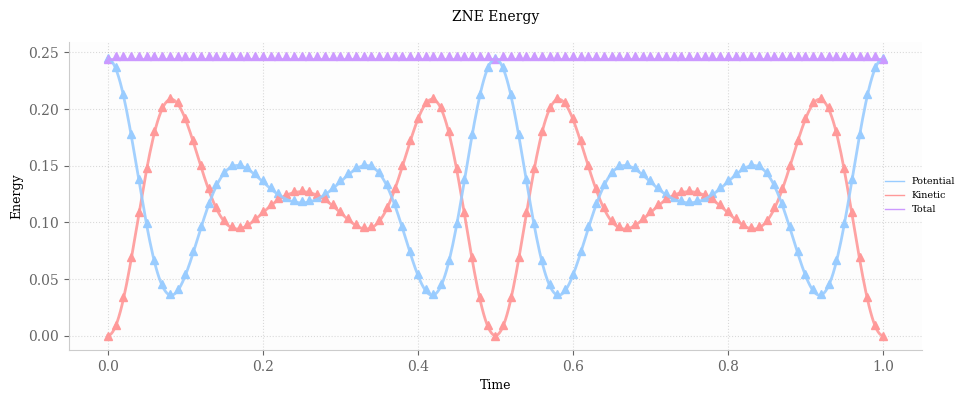

In [15]:
plt.figure(figsize=(11, 4))

plt.plot(np.linspace(0, 1, 101), U_ZNE, '^', color = colors['potential'])
plt.plot(np.linspace(0, 1, 101), T_ZNE, '^', color = colors['kinetic'])
plt.plot(np.linspace(0, 1, 101), np.array(U_ZNE) + np.array(T_ZNE), '^', color = colors['total'])


plt.plot(np.linspace(0, 1, 500), [T(_) for _ in np.linspace(0, 1, 500)], 
         color=colors['kinetic'], linewidth=2, alpha=0.9, 
         label='Kinetic')

plt.plot(np.linspace(0, 1, 500), [U(_) for _ in np.linspace(0, 1, 500)], 
         color=colors['potential'], linewidth=2, alpha=0.9, 
         label='Potential')


plt.plot(np.linspace(0, 1, 500), [U(_) + T(_) for _ in np.linspace(0, 1, 500)], 
         color=colors['total'], linewidth=2, alpha=0.9, 
         label='total')

legend_handles = [
    Line2D([0], [0], color=colors['potential'], linewidth=1
       , markerfacecolor=colors['potential'], markeredgecolor='white', markersize=6,
           label="Potential"),
    Line2D([0], [0], color=colors['kinetic'], linewidth=1,
 markerfacecolor=colors['kinetic'], markeredgecolor='white', markersize=6,
           label="Kinetic"),
    Line2D([0], [0], color=colors['total'], linewidth=1,
 markerfacecolor=colors['kinetic'], markeredgecolor='white', markersize=6,
           label="Total")
]

plt.legend(handles=legend_handles, frameon=False, fontsize=7, loc="center right", bbox_to_anchor=(1.05, 0.5))

plt.grid(True, alpha=0.3, linestyle=':', color='#888')
plt.xlabel('Time', fontsize=9)
plt.ylabel('Energy', fontsize=9)
plt.title('ZNE Energy', fontsize=10, pad=15)

# Clean styling  
plt.gca().set_facecolor('#fdfdfd')
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_color('#ccc')
ax.spines['bottom'].set_color('#ccc')
ax.tick_params(colors='#666')
plt.savefig("../Finalized Figures/ZNE_time.pdf", dpi=300)
plt.show()